In [1]:
import sys
import os

# Add the project directory to the Python path
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:
!pip install pandas openpyxl
!pip install statsmodels
!pip install arch
!pip install tensorflow
!pip install boto3
!pip install requests
!pip install numpy
!pip install joblib matplotlib
!pip install prophet

In [3]:
import pandas as pd
import numpy as np
import boto3
import joblib
import tarfile
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from scripts.preprocessing import load_data_csv, make_stationary, split_data, save_model_local, upload_model_s3, calculate_metrics
from prophet import Prophet
from scipy import stats
import seaborn as sns
from tabulate import tabulate

In [4]:
bucket = 'bk-price-prediction-data'
file_key = 'data/CEBOLLA/CEBOLLA_DATASET_1.csv'
separator = ','
df = load_data_csv(bucket, file_key, separator)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049 entries, 0 to 1048
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1049 non-null   object 
 1   PRICE   1049 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.5+ KB


In [5]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

In [6]:
df_merge = df[(np.abs(stats.zscore(df['PRICE'])) < 3)]
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1033 entries, 2004-05-23 to 2024-07-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRICE   1033 non-null   float64
dtypes: float64(1)
memory usage: 16.1 KB


In [7]:
# Normalize data
scaler = MinMaxScaler()
df_merge['PRICE'] = scaler.fit_transform(df_merge[['PRICE']])

/tmp/ipykernel_25072/1781828679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['PRICE'] = scaler.fit_transform(df_merge[['PRICE']])


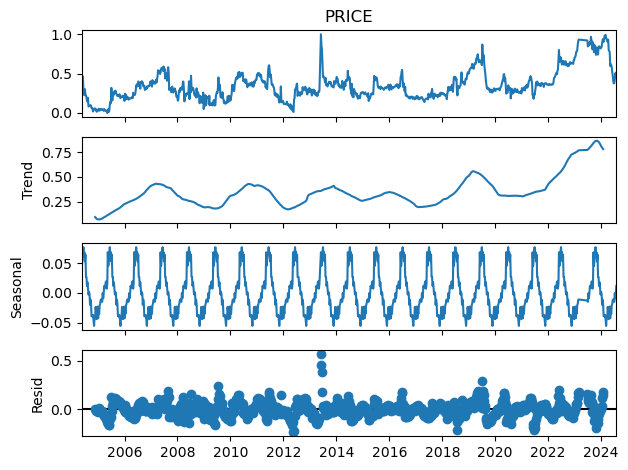

In [8]:
decomposition = seasonal_decompose(df_merge['PRICE'], model='additive', period=52)

# Plot the decomposition
decomposition.plot()
plt.show()

In [9]:
# Prepare data for Prophet
df_prophet = df_merge.reset_index().rename(columns={'DATE': 'ds', 'PRICE': 'y'})

In [10]:
train, test = split_data(df_prophet)

In [11]:
# Initialize and fit Prophet model
model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=False,
    changepoint_prior_scale=0.1,  # Adjust this parameter
    seasonality_prior_scale=10.0  # Adjust this parameter
)
model.fit(train)

19:49:17 - cmdstanpy - INFO - Chain [1] start processing
19:49:17 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Make predictions
forecast = model.predict(test)

In [13]:
# Evaluate the model
predictions = forecast['yhat'][-len(test):].values
true_values = test['y'].values

In [14]:
results=calculate_metrics(true_values,predictions)

In [15]:
print(tabulate(results, headers=["Metric", "Value"], tablefmt="grid"))

+----------+------------+
| Metric   |      Value |
+==========+============+
| MAE      |  0.165133  |
+----------+------------+
| MSE      |  0.0335151 |
+----------+------------+
| RMSE     |  0.183071  |
+----------+------------+
| MAPE     | 39.0381    |
+----------+------------+


In [16]:
name_model = 'model_cebolla'
save_model_local(model,name_model)

Created ../model/model_cebolla.tar.gz containing ../model/model_cebolla.joblib


In [17]:
# Upload the model to S3
upload_model_s3(name_model, bucket)

upload s3
